In [0]:
#!pip3 install https://download.pytorch.org/whl/cu100/torch-1.0.1.post2-cp36-cp36m-linux_x86_64.whl
#!pip3 install torchvision

In [0]:
import time

import torch
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score

import numpy as np
import PIL
import random
from IPython.core.display import Image, display

import matplotlib.pyplot as plt

In [0]:
#отключает warnings pytorch
import warnings
warnings.filterwarnings('ignore')

In [0]:
print(torch.__version__)
print(torch.cuda.is_available())

print(torch.cuda.device_count(), torch.cuda.get_device_name(0))

print(torch.cuda.current_device())
print(torch.cuda.device(0))
print("CudaVersion : ",torch.version.cuda)

1.0.1.post2
True
1 Tesla K80
0
CudaVersion :  10.0.130


In [0]:
DEVICE_ID = 0
DEVICE = torch.device('cuda:%d' % DEVICE_ID)
torch.cuda.set_device(DEVICE_ID)


In [0]:
np.random.seed(100500)

def data2image(data):
    res = np.transpose(np.reshape(data ,(3, 32,32)), (1,2,0))
    return PIL.Image.fromarray(np.uint8(res))

def imshow(img):
    if isinstance(img, torch.Tensor): img = img.numpy().astype('uint8')
    plt.imshow(np.transpose(img, (1, 2, 0)))
    
def prediction2classes(output_var):
    _, predicted = torch.max(output_var.data, 1)
    predicted.squeeze_()
    classes = predicted.tolist()
    return classes

def make_solution_pytorch(net, input_tensor, a_batch_size):
    res = []
    net = net.eval()
    cur_pos = 0
    while cur_pos <= len(input_tensor):
        outputs = net(input_tensor[cur_pos:cur_pos+a_batch_size])
        res += prediction2classes(outputs)
        cur_pos += a_batch_size
    return res

In [0]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image

class CifarDataset(Dataset):
    def __init__(self, input_path, is_train=True, transform=None):
                        
        data = np.load(input_path)
        if is_train: 
            self.Y, self.X = np.hsplit(data, [1]) 
            self.Y = [item[0] for item in self.Y]
        else: 
            self.X = data
            self.Y = None
            
        self.X = self.X.reshape((self.X.shape[0], 3, 32, 32))
        self.X = self.X.transpose((0, 2, 3, 1)) #приводим к виду (N, H, W, C)
        self.X = [Image.fromarray(img) for img in self.X]
                
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        
        sample = self.X[idx]

        if self.transform: sample = self.transform(sample)

        if self.Y is None: return sample
        else: return (sample, self.Y[idx])

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#тут папки с проблема должны быть заключены в ""
PATH_OF_DATA= '/content/gdrive/"My Drive"/"Colab Notebooks"/homework_4_ResNet'
!ls {PATH_OF_DATA}

'Copy of Kaggle_HW4_ResNet_py3.ipynb'   hw.ipynb
 homework_4_no_classes.test.npy         Kaggle_HW4_ResNet_py3.ipynb
 homework_4.train.npy		        my_solution_lenet.csv


In [0]:
#Тут папки с пробелами НЕ надо заключать в ""
DATA_PATH  = '/content/gdrive/My Drive/Colab Notebooks/homework_4_ResNet/'
train_path = 'homework_4.train.npy'
test_path  = 'homework_4_no_classes.test.npy'

In [0]:
np_mean = np.mean([item[0].numpy() for item in CifarDataset(DATA_PATH + train_path, transform=transforms.ToTensor())], axis=(0,2,3))
np_std = np.std([item[0].numpy() for item in CifarDataset(DATA_PATH + train_path, transform=transforms.ToTensor())], axis=(0,2,3))

In [0]:
np_mean, np_mean.shape

(array([0.50760865, 0.48708203, 0.44149536], dtype=float32), (3,))

In [0]:
np_std, np_std.shape

(array([0.26764476, 0.2567687 , 0.27647924], dtype=float32), (3,))

In [0]:
cifar_transform_norm = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(torch.FloatTensor(np_mean), torch.FloatTensor(np_std))
]
)

cifar_test_transform_norm = transforms.Compose([    
    transforms.ToTensor(),
    transforms.Normalize(torch.FloatTensor(np_mean), torch.FloatTensor(np_std))
]
)

In [0]:
dataset_train_norm = CifarDataset(DATA_PATH + train_path, transform=cifar_transform_norm)
dataloader_train_norm = DataLoader(dataset_train_norm, batch_size=128,
                        shuffle=True, num_workers=4)

dataset_test_norm = CifarDataset(DATA_PATH + test_path, is_train=False, transform=cifar_test_transform_norm)
dataloader_test_norm = DataLoader(dataset_test_norm, batch_size=128,
                        shuffle=False, num_workers=1)


def train_network(a_net, 
                  a_device,
                  dataloader_train_norm=dataloader_train_norm,
                  a_epochs=164,
                  a_batch_size=128,
                  a_lr=0.1):
    
    start_time = time.time()
    train_acc = []
    net = a_net.to(a_device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr, weight_decay=0.0001, momentum=0.9)

    prev_epoch_time = start_time
    for epoch in range(a_epochs):  # loop over the dataset multiple times
        if epoch == 82:
            optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr/10, weight_decay=0.0001, momentum=0.9) 
        elif epoch == 123:
            optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr/100, weight_decay=0.0001, momentum=0.9) 
        
        net = net.train()        
        epoch_accuracy = 0.0
        epoch_iters = 0
        for item in dataloader_train_norm:
            
            epoch_iters += 1

            inputs = item[0].to(a_device)
            labels = item[1].long().to(a_device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
#             prediction2classes(outputs)

#             print(labels.cpu())
#             print(prediction2classes(outputs))
            epoch_accuracy += accuracy_score(labels.cpu(), prediction2classes(outputs))

        epoch_accuracy /= epoch_iters
        train_acc.append(epoch_accuracy)
        
        print("Epoch ", epoch, round(train_acc[-1], 4))
        cur_epoch_time = time.time()
        print('Epoch time : ', cur_epoch_time - prev_epoch_time )
        prev_epoch_time = cur_epoch_time

    print('Finished Training')
    print("Total time : ", (time.time()-start_time))
    
    plt.plot(train_acc, label='Train')
    plt.legend()
#     plt.grid()
    plt.grid(c='grey')

In [0]:
DOWNSAMPLE_COEF = 2

def conv3x3(a_in_planes, a_out_planes, a_stride=1):
    """
    Основной строительный блок конволюций для ResNet
    Включает в себя padding=1 - чтобы размерность сохранялась после его применения
    """
    return nn.Conv2d(a_in_planes, a_out_planes,  stride=a_stride,
                     kernel_size=3, padding=1, bias=False)

def x_downsample(a_in_channels):
     return nn.Conv2d(a_in_channels, 
               a_in_channels*DOWNSAMPLE_COEF,
               kernel_size=1,
               stride=2,
               bias=False)

In [0]:
class CifarResidualBlock(nn.Module):
    def __init__(self, a_in_channels, make_downsample=False, use_skip_connection=True):
        super(CifarResidualBlock, self).__init__()
        self.use_skip_connection = use_skip_connection
        
        if make_downsample: coef = DOWNSAMPLE_COEF
        else: coef = 1  
        
        ### TODO - нужно описать используемые блоки
        self.make_downsample = make_downsample
        
        
        self.net = nn.Sequential()
        
        self.net.add_module('conv_1', conv3x3(a_in_channels, a_in_channels * coef, coef))
        self.net.add_module('bn_1', nn.BatchNorm2d(a_in_channels * coef))
        self.net.add_module('relu_1', nn.ReLU())
        
        self.net.add_module('conv_2', conv3x3(a_in_channels * coef, a_in_channels * coef))
        self.net.add_module('bn_2', nn.BatchNorm2d(a_in_channels * coef))
        
        if self.use_skip_connection: 
            if self.make_downsample:
                self.conv_down = x_downsample(a_in_channels)
                self.bn_down = nn.BatchNorm2d(a_in_channels * coef)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        ###TODO - описать forward блок с учетом флагов make_downsample и use_skip_connection  
        out = self.net(x)
        
        if self.use_skip_connection: 
            if self.make_downsample:
                out1 = self.conv_down(x)
                out1 = self.bn_down(out1)
                out += out1
            else:
                out += x
                
        out = self.relu(out)
        
        return out

In [0]:
class CifarResNet(nn.Module):
    
    def __init__(self):
        super(CifarResNet, self).__init__()
        
        #TODO нужно добавить блоков resnet и других слоев при необходимости
        
        self.features = nn.Sequential()
        
        #...
        k = 2
        
        self.features.add_module('conv_1', nn.Conv2d(3, 16*k, kernel_size=3))
        self.features.add_module('bn_1', nn.BatchNorm2d(16*k))
        self.features.add_module('relu_1', nn.ReLU())
        
        self.features.add_module('res_block16-1', CifarResidualBlock(16*k))
        self.features.add_module('res_block16-down', CifarResidualBlock(16*k, make_downsample=True))
        

        self.features.add_module('res_block32-1', CifarResidualBlock(32*k))
        self.features.add_module('res_block32-down', CifarResidualBlock(32*k, make_downsample=True))
        
        self.features.add_module('res_block64-1', CifarResidualBlock(64*k))
        self.features.add_module('res_block64-down', CifarResidualBlock(64*k, make_downsample=True))
        
        
        #...
        
        self.global_avg_pooling = nn.AvgPool2d(kernel_size=4)
        self.fc_classifier = nn.Linear(128*k, 100)
        
    def forward(self, x):
        x = self.features(x)
        x = self.global_avg_pooling(x)        
        x = x.view((x.size()[0], -1))        
        x = self.fc_classifier(x)        
        return x

Epoch  0 0.0974
Epoch time :  49.77915954589844
Epoch  1 0.1984
Epoch time :  44.691232681274414
Epoch  2 0.2826
Epoch time :  44.78707027435303
Epoch  3 0.3531
Epoch time :  44.828972816467285
Epoch  4 0.4184
Epoch time :  44.8935341835022
Epoch  5 0.4692
Epoch time :  44.880603075027466
Epoch  6 0.5072
Epoch time :  44.865668296813965
Epoch  7 0.54
Epoch time :  44.71931600570679
Epoch  8 0.5629
Epoch time :  44.78134322166443
Epoch  9 0.5879
Epoch time :  44.81944727897644
Epoch  10 0.6062
Epoch time :  44.867700815200806
Epoch  11 0.6241
Epoch time :  44.8855881690979
Epoch  12 0.6356
Epoch time :  44.809526205062866
Epoch  13 0.6469
Epoch time :  44.79983949661255
Epoch  14 0.658
Epoch time :  44.78819990158081
Epoch  15 0.6723
Epoch time :  44.7940948009491
Epoch  16 0.6804
Epoch time :  44.80095982551575
Epoch  17 0.6947
Epoch time :  44.787517786026
Epoch  18 0.6977
Epoch time :  44.81609296798706
Epoch  19 0.7129
Epoch time :  44.85882544517517
Epoch  20 0.7156
Epoch time :  4

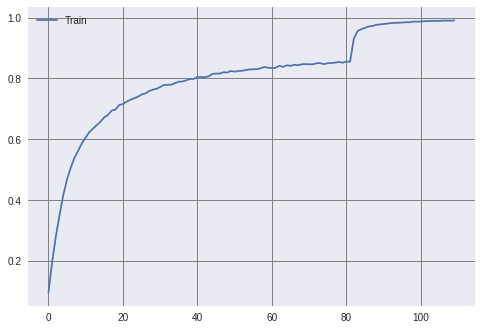

In [0]:
resnet = CifarResNet()
train_network(resnet, torch.device(DEVICE), a_epochs = 110)

# Важно переключить сеть в режим eval - иначе dropout будет работать некорректно

In [0]:
def make_solution(a_net, a_device):
    res = []
    net = a_net.eval()
    for item in dataloader_test_norm:
        inputs = item.to(a_device)
        outputs = net(inputs) 

        res += prediction2classes(outputs)
    return res

In [0]:
my_solution = make_solution(resnet, DEVICE)

In [0]:
file_name = DATA_PATH + 'my_solution_resnet.csv'

with open(file_name, 'w') as fout:
    print('Id', 'Prediction', sep=',', file=fout)
    for i, prediction in enumerate(my_solution):
        print(i, prediction, sep=',', file=fout)
        
from google.colab import files
files.download(file_name)